## Customer Segmentation for Online Retail store

We endeavour to find the various customer segments using the online retail store's transaction data obtained from [UCI Machine Learning Dataset repository](http://archive.ics.uci.edu/ml/datasets/online+retail). This is a transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail.

### The need of customer segmentation:   
The differences in customers' behaviour, demographics, geographies, etc. help in classifying them in groups. Learning about different groups in the customer can help with following:    

1. Target Marketing    
2. Client understanding
3. Optimal product placement
4. Searching for new customers
5. Revenue growth   


### Recency-Frequency-Monetary (RFM)  model to determine customer value:    

The RFM model is quite useful model in retail customer segmentation where only the data of customer transaction is available. RFM stands for the three dimensions:

 - *Recency* – How recently did the customer purchase?
 - *Frequency* – How often do they purchase?
 - *Monetary Value* – How much do they spend?    
 

A combination of these three attributes can be defined to assign a quantitative value to customers. e.g. A customer who recently bought high value products and transacts regularly is a high value customer. 

In [97]:
#Load all the required packages
import pandas as pd
import numpy as np
import datetime
import math
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

### 1. Import Data

In [47]:
dfRetail = pd.read_excel(io="Online Retail.xlsx")
dfRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### 2. Exploratory Data Analysis

#### 2.1. Top 10 ordering countries

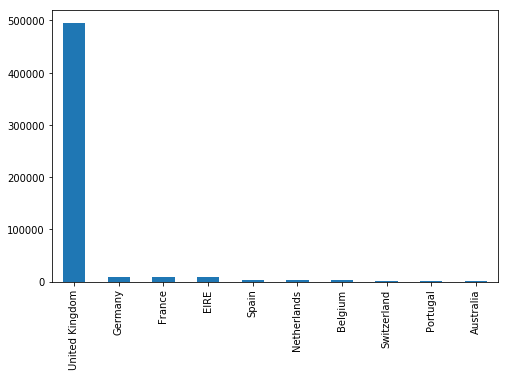

In [11]:
dfRetail.Country.value_counts().head(10).plot.bar(figsize=(8,5))

#### 2.2. Unique customers and order share of top customers 

In [14]:
    len(dfRetail.CustomerID.unique())

4373

There are 4373 unique customer records in the dataset

In [26]:
(dfRetail.CustomerID.value_counts()/sum(dfRetail.CustomerID.value_counts())*100).head(n=15).cumsum()

17841.0     1.962249
14911.0     3.413228
14096.0     4.673708
12748.0     5.814728
14606.0     6.498553
15311.0     7.110850
14646.0     7.623350
13089.0     8.079807
13263.0     8.492020
14298.0     8.895138
15039.0     9.265809
14156.0     9.614850
18118.0     9.930462
14159.0    10.228376
14796.0    10.514737
Name: CustomerID, dtype: float64

It is seen that only 10 out of 4000+ customers are responsible for 10% of total orders. These must be the wholesale customers of the retail store

#### 2.3. Unique item stock codes and their description

In [30]:
#Find number of unique items in stock
print(f"Number of unique item stock codes: {len(dfRetail.StockCode.unique())}")
print(f"Number of unique item descriptions: {len(dfRetail.Description.unique())}")

Number of unique item stock codes: 4070
Number of unique item descriptions: 4224


The count of unique stock unit ids and their descriptions should have matched but they do not. This implies some stock units might have more than one descriptions. Let us examine the reasons behind this *data quality* issue:

In [32]:
#Find out the stock units that have more than one description
dfStockDesc = dfRetail.groupby(["StockCode","Description"]).count().reset_index()
dfStockDesc.StockCode.value_counts()[dfStockDesc.StockCode.value_counts()>1].reset_index().head()

,index,StockCode
0,20713,8
1,23084,7
2,21830,6
3,85175,6
4,21181,5


Now, let us examine how a single unit code has multiple description:

In [42]:
dfRetail[dfRetail['StockCode'] == 
         dfStockDesc.StockCode.value_counts()
         [dfStockDesc.StockCode.value_counts()>1].reset_index()
         ['index'][8]]['Description'].unique()

array(['MISTLETOE HEART WREATH CREAM', 'MISELTOE HEART WREATH WHITE',
       'MISELTOE HEART WREATH CREAM', '?', 'had been put aside', nan],
      dtype=object)

We notice that this description is a manually entered field and thus has discrepancies and inconsistencies. However, since the objective of this task is customer segmentation, we avoid exploring and resolving this issue further

#### 2.4. Exploring Quantity and Unit Price fields

In [43]:
dfRetail.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

We see 10 goods being sold on an average with a standard deviation of around 200. Also, the minimum quantity includes a negative value, this implies that the dataset includes returned items as well, a common scenario in retail domain

In [44]:
dfRetail.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

The unit price field echoes the similar observations as Quantity variable

    
### 3. Data preprocessing and filtering:    

<strong>1. Filter UK only data: </strong>     
We noticed in the exploratory data analysis phase that majority of the transactions belonged to UK, so it makes sense to consider only this country data for maximum impact

In [48]:
dfRetail = dfRetail[dfRetail.Country == "United Kingdom"]

<strong>2. Calculate total transaction amount:</strong>    
Compute the total value of transaction based on quantity sold and per unit price.

In [85]:
dfRetail["Amount"] = dfRetail["Quantity"] * dfRetail["UnitPrice"]

<strong>3. Exclude return transactions: </strong>     
We remove the negative (return goods) transactions before proceeding with the analysis.   

In [53]:
dfRetail = dfRetail[dfRetail.Amount >= 0]
dfRetail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


<strong>4. Exclude records without customer IDs: </strong>     
Since, we concentrate on the task of customer segmentation, we exclude the transaction records that failed to capture the CustomerID

In [57]:
dfRetail = dfRetail[~dfRetail.CustomerID.isnull()]
dfRetail.shape

(354345, 9)

### 4. Feature Engineering - Building features for RFM model:  

### 1. Recency: 
We fix a reference date for finding the recent transactions. The reference date would be a day after the most recent transaction date in the dataset. Then we calculate the days difference between the most recent transaction carried out by the customer and this reference date

In [76]:
referenceDate = dfRetail['InvoiceDate'].max()
referenceDate += datetime.timedelta(days = 1)

dfRetail['Recency'] = (referenceDate - dfRetail['InvoiceDate']).astype('timedelta64[D]')
dfCustomerHistory = dfRetail.groupby("CustomerID").min().reset_index()[['CustomerID', 'Recency']]
dfCustomerHistory.head()

,CustomerID,Recency
0,12346.0,326.0
1,12747.0,2.0
2,12748.0,1.0
3,12749.0,4.0
4,12820.0,3.0


Distribution of customer recency:

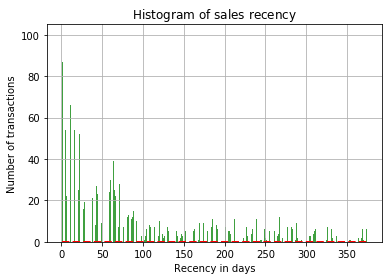

In [79]:
x = dfCustomerHistory.Recency
mu = np.mean(dfCustomerHistory.Recency)
sigma = math.sqrt(np.var(dfCustomerHistory.Recency))
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
y = mlab.normpdf( bins, mu, sigma)
l = plt.plot(bins, y, 'r--', linewidth=2)
plt.xlabel('Recency in days')
plt.ylabel('Number of transactions')
plt.title(r'$\mathrm{Histogram\ of\ sales\ recency}\ $')
plt.grid(True)

We notice that there have been quite a high number of recent transactions and lesser number of transactions that are older

### 2. Frequency:     
Calculate the frequency of transactions for each customer

In [87]:
dfCustomerFrequency = dfRetail[['CustomerID', 'Amount']].groupby('CustomerID').count().reset_index()
dfCustomerFrequency.rename(columns={'Amount': 'Frequency'}, inplace= True)
dfCustomerHistory = dfCustomerHistory.merge(dfCustomerFrequency, how="outer")
dfCustomerHistory.head()

,CustomerID,Recency,Frequency
0,12346.0,326.0,1
1,12747.0,2.0,103
2,12748.0,1.0,4596
3,12749.0,4.0,199
4,12820.0,3.0,59


### 3. Monetary value:

In [89]:
dfCustomerMV = dfRetail[['CustomerID', 'Amount']].groupby('CustomerID').sum().reset_index()
dfCustomerMV.rename(columns={'Amount': 'MonetaryValue'}, inplace= True)
dfCustomerHistory = dfCustomerHistory.merge(dfCustomerMV, how="outer")
#add a small number to monetary value to avoid problems with zeros as we transform to log scale
dfCustomerHistory["MonetaryValue"] = dfCustomerHistory["MonetaryValue"] + 0.001
dfCustomerHistory.head()

,CustomerID,Recency,Frequency,MonetaryValue
0,12346.0,326.0,1,77183.601
1,12747.0,2.0,103,4196.011
2,12748.0,1.0,4596,33719.731
3,12749.0,4.0,199,4090.881
4,12820.0,3.0,59,942.341


### 5. Feature Scaling:    
Since, all the features like *Recency, Frequency and Monetary value* are within varying ranges of values, we need to standardize them. In addition, the feature like *"Monetary value"* can take a very large range of values. So, to standardize all the inputs features, we apply log transform, so that the input to our clustering algorithm is a set of well scaled and transformed features.

In [91]:
#Applying log transformations
dfCustomerHistory['log_Recency'] = dfCustomerHistory["Recency"].apply(math.log)
dfCustomerHistory['log_Frequency'] = dfCustomerHistory["Frequency"].apply(math.log)
dfCustomerHistory['log_MonetaryValue'] = dfCustomerHistory["MonetaryValue"].apply(math.log)

#Preparing matrix for standard scaling transformation
X = dfCustomerHistory[["log_Recency", "log_Frequency", "log_MonetaryValue"]].as_matrix()
#Standardize the features (mean 0 and std. dev 1)
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

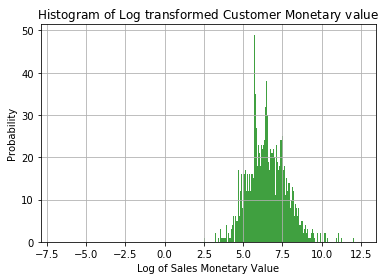

In [92]:
x = dfCustomerHistory.log_MonetaryValue
n, bins, patches = plt.hist(x, 1000, facecolor='green', alpha=0.75)
plt.xlabel('Log of Sales Monetary Value')
plt.ylabel('Probability')
plt.title(r'$\mathrm{Histogram\ of\ Log\ transformed\ Customer\ Monetary\ value}\ $')
plt.grid(True)
plt.show()

In [93]:
dfCustomerHistory.head()

,CustomerID,Recency,Frequency,MonetaryValue,log_Recency,log_Frequency,log_MonetaryValue
0,12346.0,326.0,1,77183.601,5.786897,0.000000,11.253942
1,12747.0,2.0,103,4196.011,0.693147,4.634729,8.341890
2,12748.0,1.0,4596,33719.731,0.000000,8.432942,10.425838
3,12749.0,4.0,199,4090.881,1.386294,5.293305,8.316516
4,12820.0,3.0,59,942.341,1.098612,4.077537,6.848367


### 6. Visualizing the relationship between R, F and M:

Text(0.5,0,'MonetaryValue')

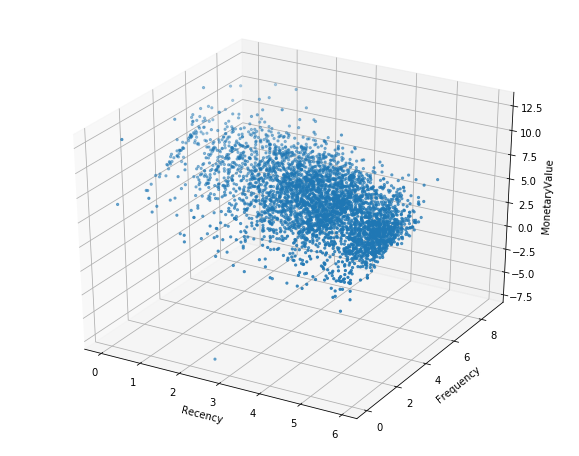

In [96]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

xs =dfCustomerHistory.log_Recency
ys = dfCustomerHistory.log_Frequency
zs = dfCustomerHistory.log_MonetaryValue
ax.scatter(xs, ys, zs, s=5)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('MonetaryValue')

#### <font color="blue">Observations:</font>    
1. Customers who recently bought items, are also the ones who buy more freqently and place high value orders
2. Customers who transacted long time ago, also place lower valued orders   
3. Customers who buy occasionally, do not tend to buy expensive items

### 7. Customer segmentation through clustering:
Clustering is an unsupervised classification techinque to understand the groups of classes in the data. We use the **K-means clustering algorithm** to determine the ideal segments of customers.    

   
<b><font color="brown">Silhouette Analysis - Determine optimum number of segments</font></b>    
Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually.

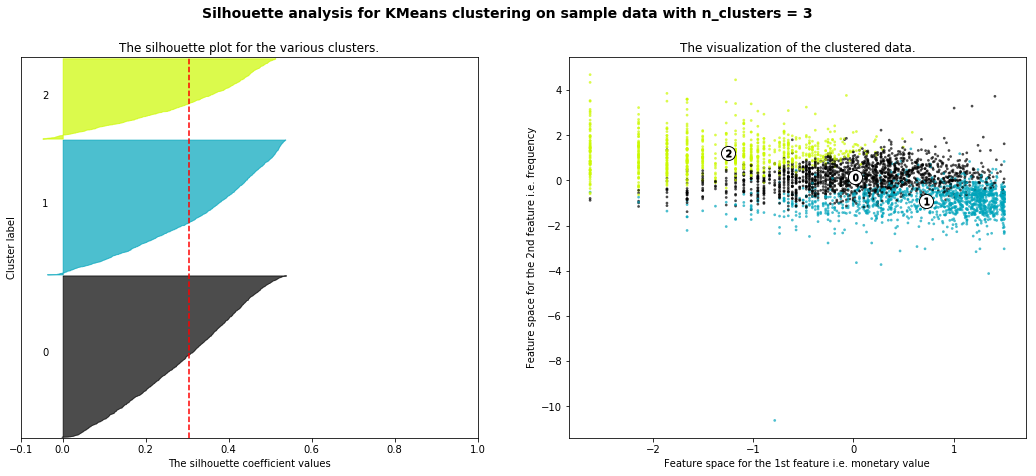

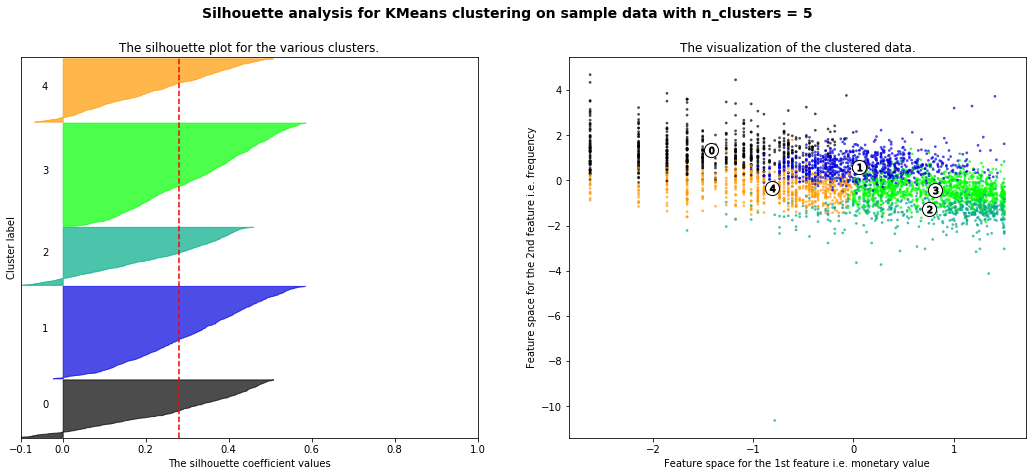

In [98]:
X = X_scaled

cluster_centers = dict()

for n_clusters in range(3,6,2):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    #Train a K-means clustering model with 3/ 5 clusters
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    
    #classify cluster labels based on training data
    cluster_labels = clusterer.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels)
    cluster_centers.update({n_clusters :{
                                        'cluster_center':clusterer.cluster_centers_,
                                        'silhouette_score':silhouette_avg,
                                        'labels':cluster_labels}
                           })

    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:, feature1], X[:, feature2], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:, feature1], centers[:, feature2], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')
    for i, c in enumerate(centers):
        ax2.scatter(c[feature1], c[feature2], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
    ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

## 8.Cluster Analysis & Business Relevance:   

We have obtained a visualization of clusters (customer segments) but in order to reach at any conclusion, we need to inspect the recency, frequency and monetary values associated with each cluster. First, we need to convert back the log transformed values.

In [100]:
for i in range(3,6,2):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(cluster_centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=["log_Recency", "log_Frequency", "log_MonetaryValue"]))
    print("Silhouette score for cluster {} is {}". format(i, cluster_centers[i]['silhouette_score']))
    print()

for 3 number of clusters
   log_Recency  log_Frequency  log_MonetaryValue
0    44.083222      53.920633         843.937271
1   121.766072      10.668661         221.236034
2     7.196647     177.789098        3159.294272
Silhouette score for cluster 3 is 0.30437444714898737

for 5 number of clusters
   log_Recency  log_Frequency  log_MonetaryValue
0     5.627973     214.465989        3905.544371
1    46.880212      92.306262        1502.519606
2   126.546751       5.147370         142.867249
3   139.056216      25.530424         408.235418
4    13.386419      29.581298         464.371885
Silhouette score for cluster 5 is 0.27958641427323727



### <font color="blue">Observations and Inferences:</font>    

<strong>1. Three Clusters (Customer Segments): </strong>    
Carefully examining the three cluster classification, we observe following groups of customers:    
 1. **High value customer:**     
 *'Cluster 2'* is the high value customer segment for the online retails store as the customers in this group place the highest value orders with a very high relative frequency than other members. They are also the ones who have transacted the most recently.    
 2. **Medium value customer: **     
 *'Cluster 0'* appears to be the medium valued customer segment. These customers place an order of a considerable amount, though not as much as high valued customers, but still quite higher than low valued customers. Also, their orders are relatively more frequent than the lowest value segment.    
 3. **Low value customer: **    
  It is quite evident that *'Cluster 1'* has customers who rarely shop and when they order, their orders are pretty low valued. 
     Apart from the numbers, the visualization of clusters in *Silhoutte Analysis* show that all three customer segments are quite distinct with very less overlapp between them. The general trend resonated in these 3 clusters is that high monetary value is correlated with high frequency of orders and more recent ones. 
   
<strong>2. Five Clusters (Customer Segments): </strong>    
In five clusters, we find the following customer segments:   
 1. **Overall high valued customers: **     
 *'Cluster 0'* is the typical high value customer who has shopped recently and shops regularly for high value orders. 
 2. **High monetary value but less frequent: **     
 *'Cluster 1'* represents a peculiar customer segment who place quite a high valued order but do not do so frequently or have not done much recently. But, these customers do hold a lot of promise if targeted to improve sales.        
 3. **Medium value - low frequency - recent customers: **      
  The customers from *'Cluster 4'* have recently placed medium valued orders but do not do so frequently.     
 4. **Medium value - low frequency - older customers: **  
  The customers from *'Cluster 3'* happen to place medium valued orders quite a long time ago and they do not do so frequently.     
 5. **Low valued customers: **     
 *'Cluster 2'* is the segment of customers who have not shopped in the longest time, nor do they shop frequently and their orders are of the lowest values.     
 The visualization of clusters in *Silhoutte Analysis* show some overlapp between the customer segments.    
 However, the dataset does not distinguish between wholesale and retail customers, it is quite likely that high value frequent clients are the wholesale dealers and medium/ low valued ones are individual retail purchasers.
 
### Conclusion:    
The customer segments thus deduced can be very useful in targeted marketing, scouting for new customers and ultimately revenue growth. After knowing the types of customers, it depends upon the retailer policy whether to chase the high value customers and offer them better service and discounts or try and encourage low/ medium value customers to shop more freqently or of higher monetary values.